<a href="https://colab.research.google.com/github/Manvi1718/FER_XAI/blob/main/HiResCAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Path to the saved model
model_path = '/content/drive/MyDrive/train_test/Emotion_Analysis_Model/ResNet50.pth'

# Load the ResNet50 model
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 7)  # Assuming 7 classes for emotions
model.load_state_dict(torch.load(model_path))
model.eval()
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-4-ac2a70dd59d0>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

In [5]:
class HiResCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.hooks = []
        self.register_hooks()

    def register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        for name, module in self.model.named_modules():
            if name == self.target_layer:
                self.hooks.append(module.register_forward_hook(forward_hook))

    def __call__(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax().item()

        activations = self.activations.cpu().numpy()[0]

        # Compute weights directly from the activations' global average
        weights = np.mean(activations, axis=(1, 2))
        hi_res_cam_map = np.sum(weights[:, None, None] * activations, axis=0)

        # Post-process the CAM map
        hi_res_cam_map = np.maximum(hi_res_cam_map, 0)
        hi_res_cam_map = cv2.resize(hi_res_cam_map, (input_tensor.shape[2], input_tensor.shape[3]))
        hi_res_cam_map -= hi_res_cam_map.min()
        hi_res_cam_map /= hi_res_cam_map.max()

        return hi_res_cam_map

    def __del__(self):
        for hook in self.hooks:
            hook.remove()


In [6]:
# Image folder path
image_folder = '/content/drive/MyDrive/FER_Images'

# Transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize HiResCAM for the target layer
target_layer = 'layer4'  # Choose the final convolutional layer of ResNet50
hirescam = HiResCAM(model, target_layer)

In [9]:
emotion_images = ['anger', 'contempt', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']
results = {}

for emotion in emotion_images:
    img_path = os.path.join(image_folder, f"{emotion}.png")
    img = Image.open(img_path).convert('RGB')
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Get HiResCAM heatmap
    hi_res_cam_map = hirescam(input_tensor)

    # Convert the original and heatmap to numpy for plotting
    original_img = np.array(img.resize((224, 224)))
    heatmap = cv2.applyColorMap(np.uint8(255 * hi_res_cam_map), cv2.COLORMAP_INFERNO)
    heatmap_overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

    # Store images for visualization
    results[emotion] = (original_img, heatmap_overlay, heatmap)

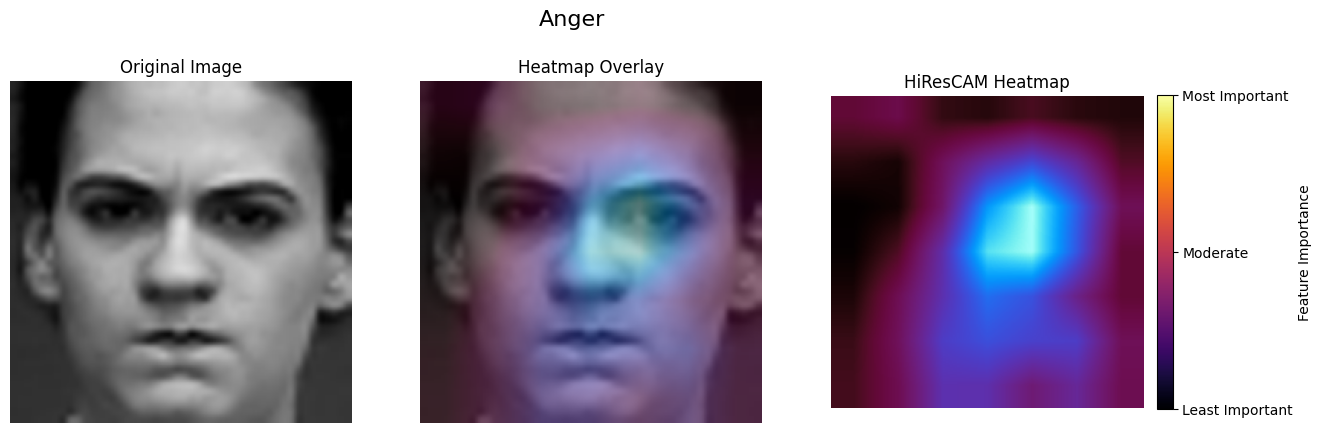

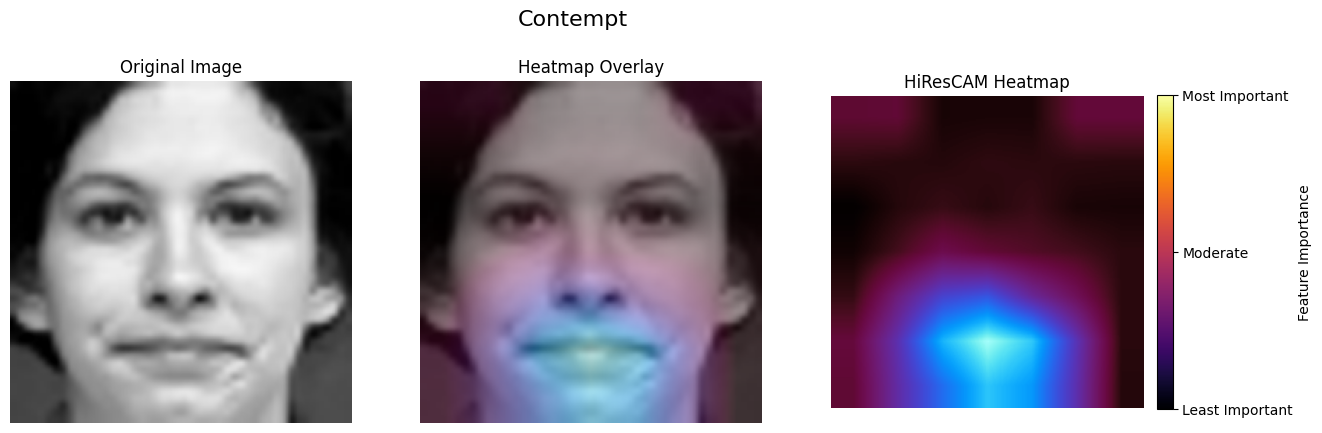

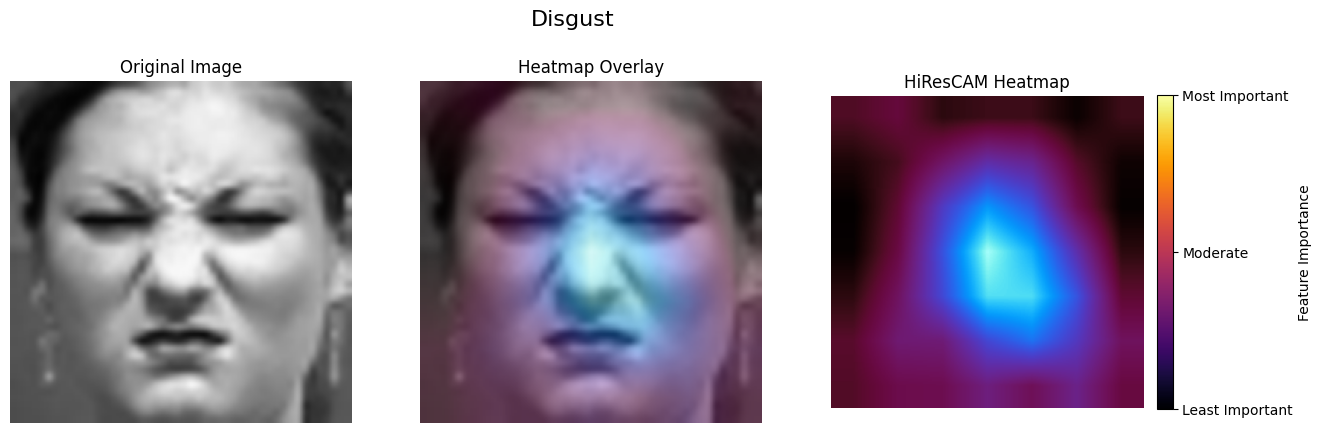

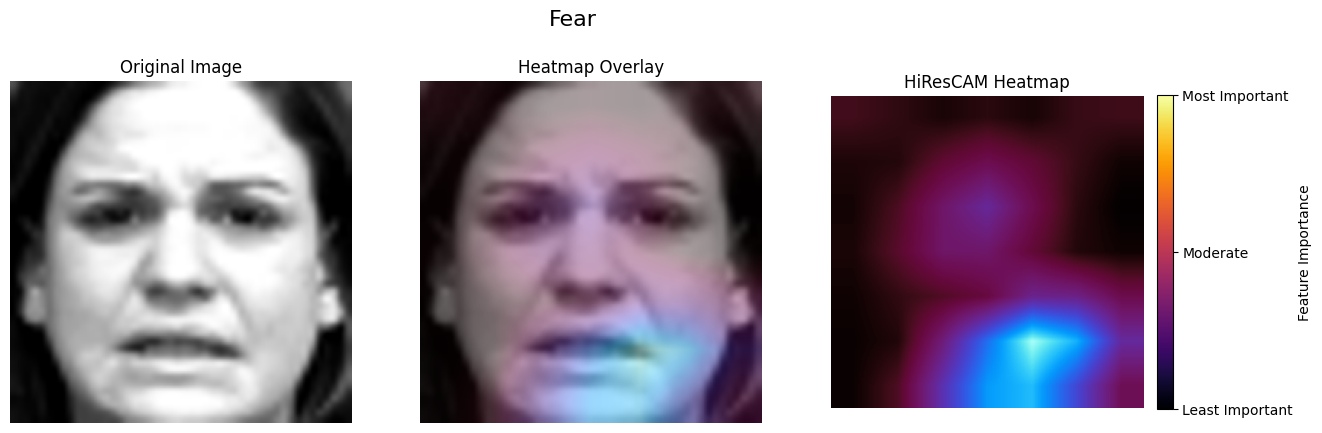

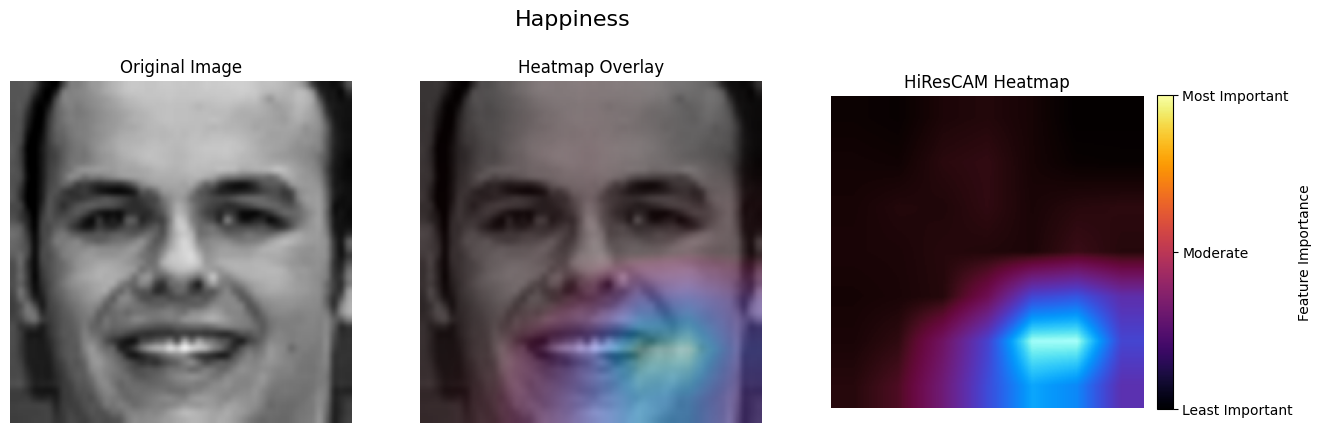

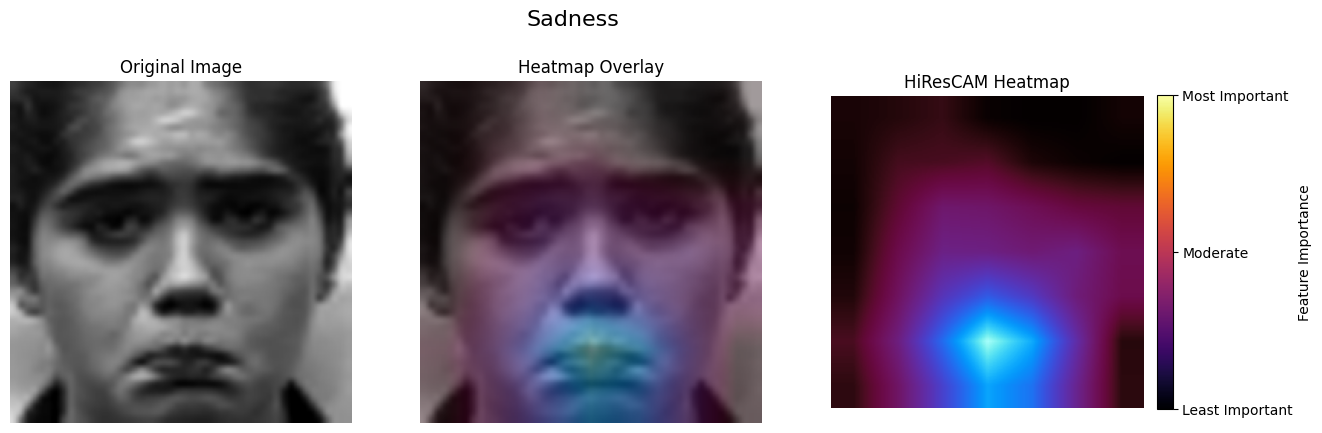

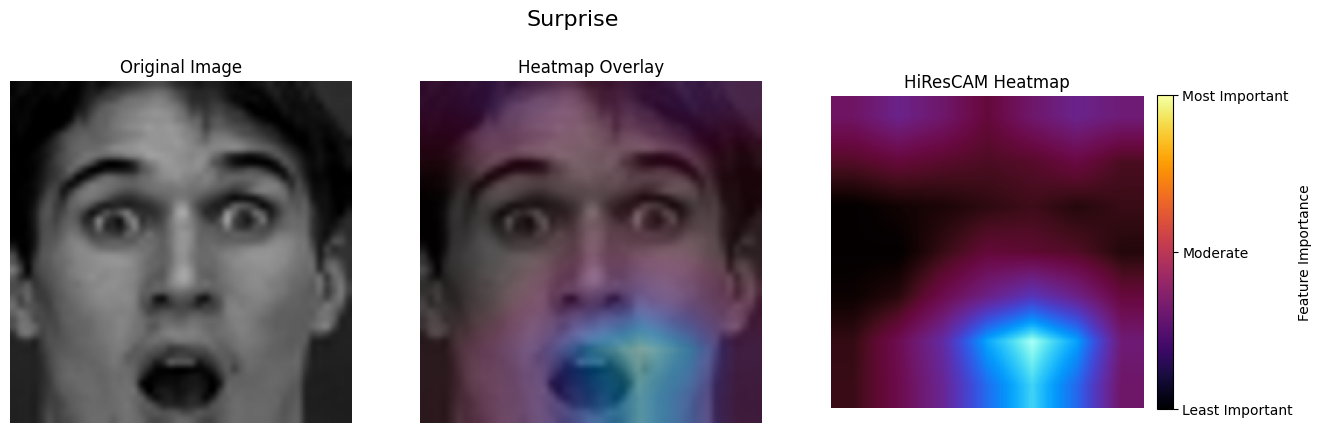

In [10]:
# Plotting with colorbar
for emotion, (original_img, heatmap_overlay, heatmap) in results.items():
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(emotion.capitalize(), fontsize=16)

    # Original Image
    ax[0].imshow(original_img)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Heatmap Overlay
    ax[1].imshow(heatmap_overlay)
    ax[1].set_title('Heatmap Overlay')
    ax[1].axis('off')

    # Standalone Heatmap with Colorbar (using 'inferno' colormap)
    heatmap_img = ax[2].imshow(heatmap, cmap='inferno')
    ax[2].set_title('HiResCAM Heatmap')
    ax[2].axis('off')

    # Add colorbar matching the 'inferno' colormap
    cbar = fig.colorbar(heatmap_img, ax=ax[2], fraction=0.046, pad=0.04)
    cbar.set_label('Feature Importance')
    cbar.set_ticks([0, 127.5, 255])
    cbar.set_ticklabels(['Least Important', 'Moderate', 'Most Important'])

    plt.show()